In [2]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_line, theme_minimal, theme, element_text, labs, facet_grid, labeller
ROOT_DIR = Path('/Users/carlo/mpwavelets')
RESULTS_DIR = ROOT_DIR / 'results'
FIGURES_DIR = ROOT_DIR / 'figures'


In [3]:
def mp_acceleration(y, v, fp=1, A=1, dt=0.01):
    duration = y / fp
    gp = (y + 1)/y
    gm = (y - 1)/y
    w = 2 * np.pi * fp
    phase = - np.pi * y + v
    time = np.arange(0., duration + dt, dt)
    accel = - 0.25 * A * w * ( gp * np.sin(gp * w * time + phase)  + gm * np.sin(gm * w * time + phase)  - 2 * np.sin( w * time + phase ) )
    zeros = np.zeros(int(9*duration/dt))
    accel_input = np.concatenate([accel, zeros])
    return time, accel, duration, accel_input

In [31]:
# Create uniform grid of y and v values
y_values = np.linspace(1, 3, 11)
y_values_display = ['1', '1.2', '1.4', '1.6', '1.8', '2', '2.2', '2.4', '2.6', '2.8', '3']
v_values = np.linspace(0, 5*np.pi/3, 6)
v_values_display = ['0', '1/3 \pi', '2/3 \pi', '\pi', '4/3 \pi', '5/3 \pi']

# Create meshgrid for all combinations
Y, V = np.meshgrid(y_values, v_values)

# Flatten arrays for iteration
y_flat = Y.flatten()
v_flat = V.flatten()

# Store results
results = []
dur = 0
for y, y_display in zip(y_values, y_values_display):
    for v, v_display in zip(v_values, v_values_display):
        time, accel, duration, accel_input = mp_acceleration(y, v)
        # Create timeseries for each result
        if duration > dur:
            dur = duration
        name_str = f'$\\gamma={y_display} \\quad \\nu={v_display}$'
        ts = pd.Series(accel, index=time, name=name_str)
        results.append(ts)
results, dur

([0.00   -0.000000e+00
  0.01    1.964837e-01
  0.02    3.875364e-01
  0.03    5.678216e-01
  0.04    7.321915e-01
              ...     
  0.96   -7.321915e-01
  0.97   -5.678216e-01
  0.98   -3.875364e-01
  0.99   -1.964837e-01
  1.00   -7.694683e-16
  Name: $\gamma=1 \quad \nu=0$, Length: 101, dtype: float64,
  0.00   -0.000000e+00
  0.01    8.215702e-02
  0.02    1.297459e-01
  0.03    1.410448e-01
  0.04    1.150392e-01
              ...     
  0.96   -6.171523e-01
  0.97   -4.267768e-01
  0.98   -2.577904e-01
  0.99   -1.143267e-01
  1.00   -3.487868e-16
  Name: $\gamma=1 \quad \nu=1/3 \pi$, Length: 101, dtype: float64,
  0.00   -0.000000e+00
  0.01   -1.143267e-01
  0.02   -2.577904e-01
  0.03   -4.267768e-01
  0.04   -6.171523e-01
              ...     
  0.96    1.150392e-01
  0.97    1.410448e-01
  0.98    1.297459e-01
  0.99    8.215702e-02
  1.00   -1.046361e-15
  Name: $\gamma=1 \quad \nu=2/3 \pi$, Length: 101, dtype: float64,
  0.00   -0.000000e+00
  0.01   -1.964837e-01


In [32]:
name_str

'$\\gamma=3 \\quad \\nu=5/3 \\pi$'

In [33]:
results[0]

0.00   -0.000000e+00
0.01    1.964837e-01
0.02    3.875364e-01
0.03    5.678216e-01
0.04    7.321915e-01
            ...     
0.96   -7.321915e-01
0.97   -5.678216e-01
0.98   -3.875364e-01
0.99   -1.964837e-01
1.00   -7.694683e-16
Name: $\gamma=1 \quad \nu=0$, Length: 101, dtype: float64

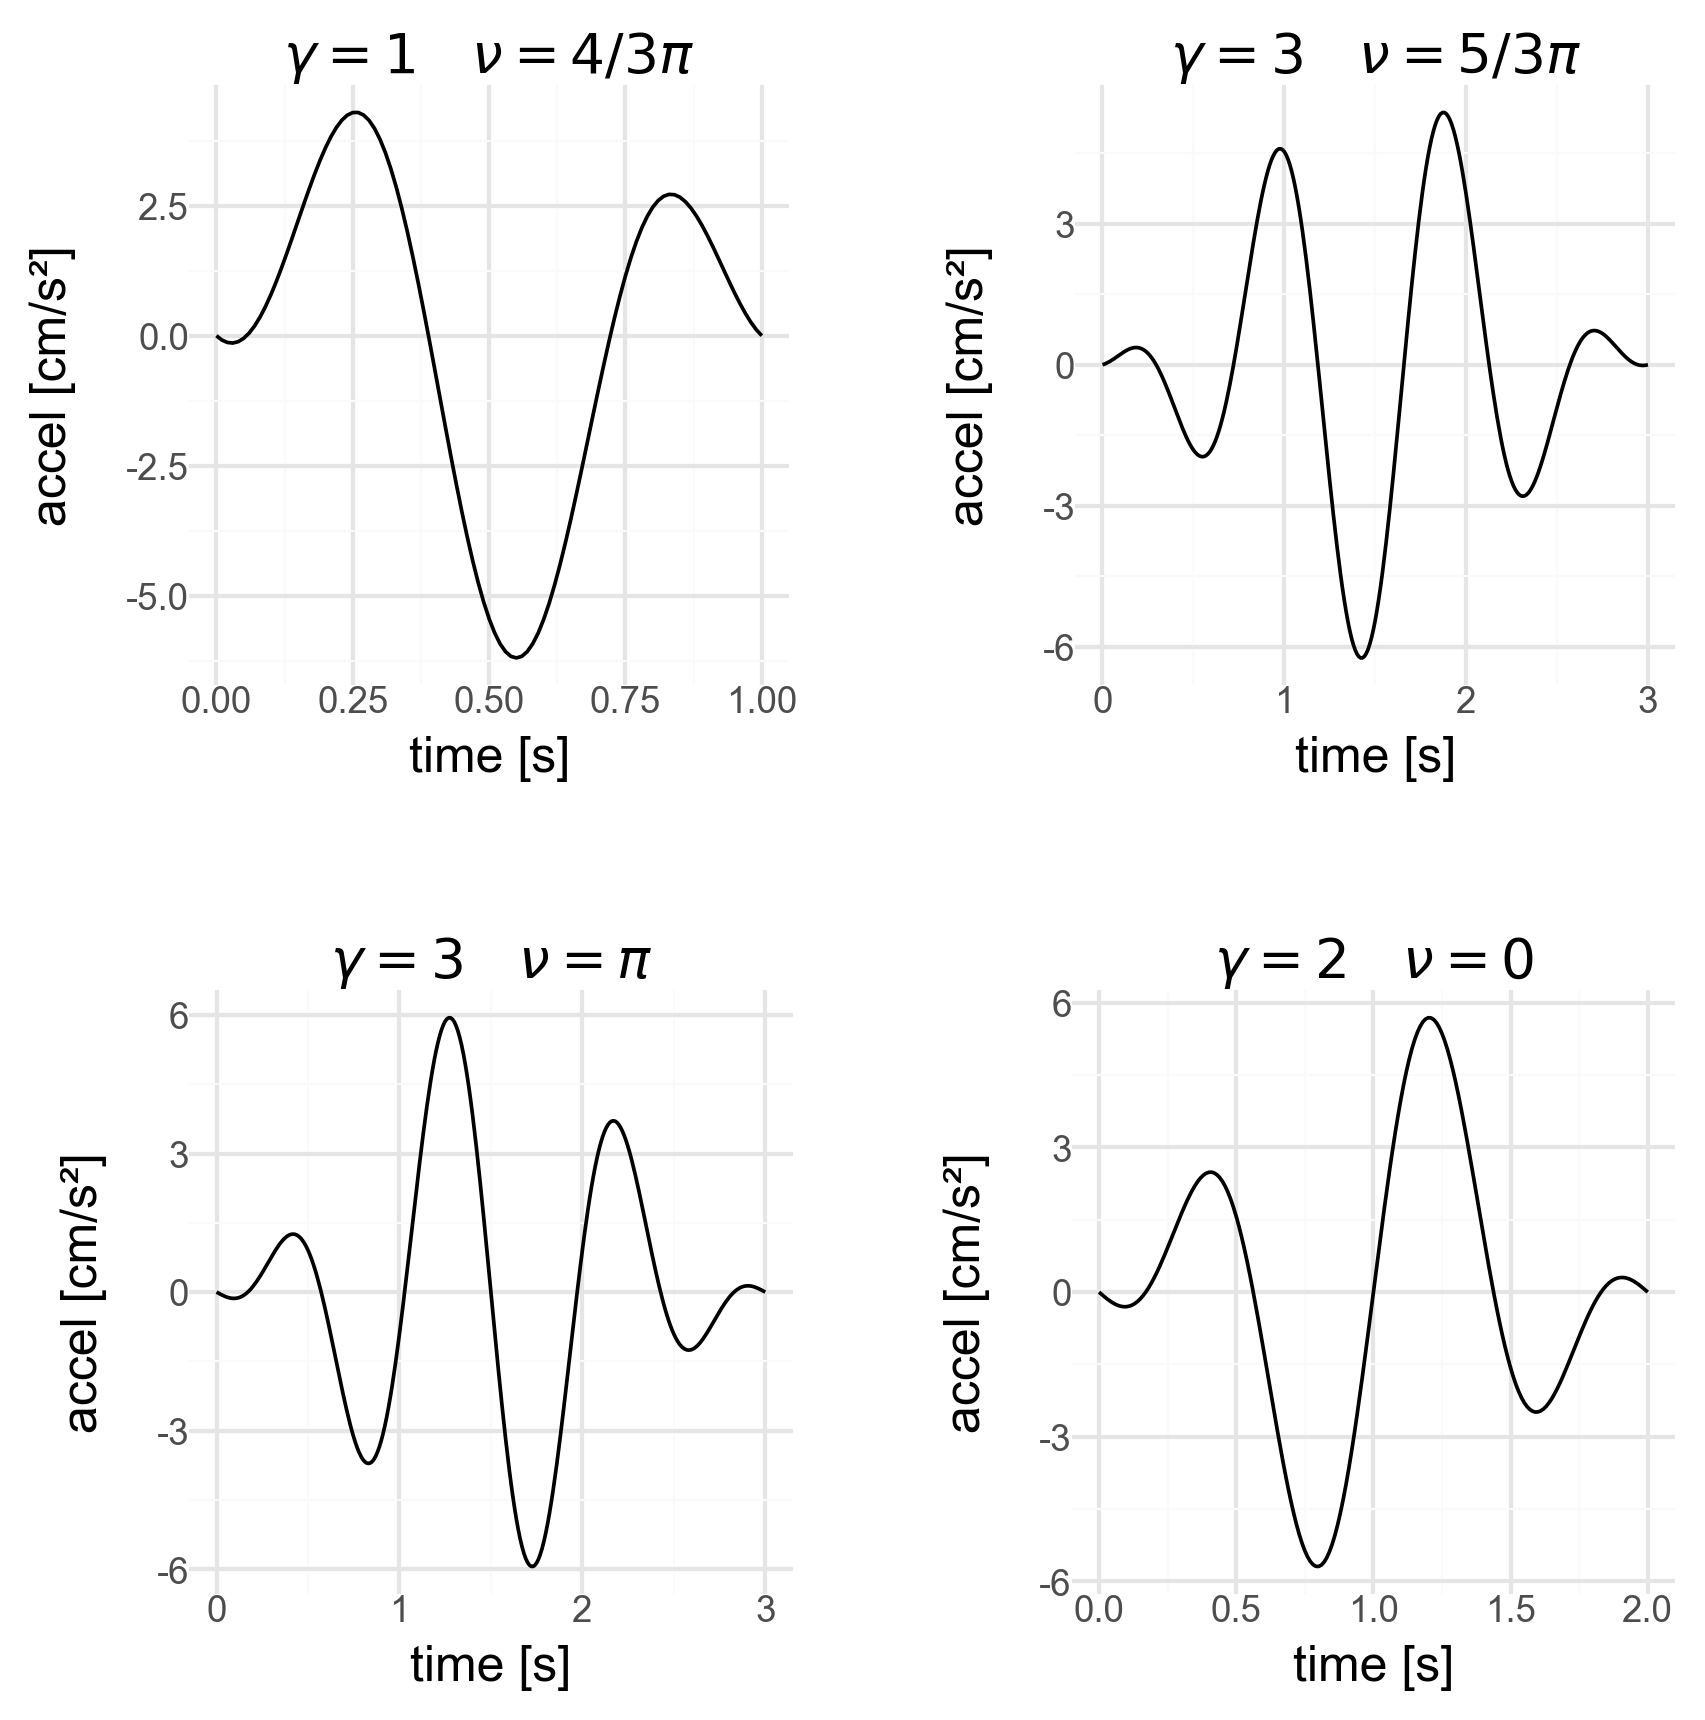

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [34]:
# Randomly select 25 series from results
import random
import plotnine as p9
from plotnine import ggplot, aes, geom_line, facet_wrap
import patchworklib as pw
random_indices = random.sample(range(len(results)), 4)

# Create a list to store the plots
plots = []

# Create individual plots
for idx in random_indices:
    series = results[idx]
    # Convert LaTeX title to matplotlib mathtext
    plot = (ggplot(series.reset_index(), aes(x='index', y=series.name))
            + geom_line()
            + p9.theme_minimal()
            + p9.labs(x='time [s]', 
                     y='accel [cm/s²]',
                     title=series.name))
    plots.append(pw.load_ggplot(plot, figsize=(2, 2)))

# Arrange in 2x2 grid
grid = (plots[0] | plots[1]) / (plots[2] | plots[3])

# Save or show the combined plot
grid.savefig("2x2_series_grid.png")
# Display the plot
grid


In [39]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplot figure with 2x2 grid
nrows = 6
ncols = 5
num = nrows * ncols
random_indices = random.sample(range(len(results)), num)
subresults = [results[i] for i in random_indices]

titles = [s.name for s in subresults]
fig = make_subplots(rows=nrows, cols=ncols, vertical_spacing=0.04, horizontal_spacing=0.02, subplot_titles=titles)

# Add traces for each randomly selected series
ix = 0
for rix, row in enumerate(range(nrows), 1):
    for cix, col in enumerate(range(ncols), 1):
        series = subresults[ix]
        fig.add_trace(
            go.Scatter(
                x=series.index,
                y=series.values,
                name=series.name,
                mode='lines',
                line=dict(color='gray')
            ),
            row=rix,
            col=cix
        )
        
        fig.update_xaxes(
            showgrid=False,
            ticks='inside',
            showline=True,
            linewidth=1,
            mirror=True,
            linecolor='gray',
            zerolinewidth=0.,
            row=rix,
            col=cix
        )

        fig.update_yaxes(
            showgrid=False,
            ticks='inside',
            showline=True,
            linewidth=1,
            mirror=True,
            linecolor='gray',
            zerolinewidth=0.,
            row=rix,
            col=cix
        )

        fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
        if rix == nrows:
            fig.update_xaxes(title_text='t [s]', row=rix, col=cix)
            fig.update_annotations(font=dict(size=12), row=rix, col=cix)
        if cix == 1:
            fig.update_yaxes(title_text='aₚ(t) [cm/s²]', row=rix, col=cix)

        ix += 1

pxs = 1440
fig.update_layout(
    width=pxs,
    height=nrows/ncols*pxs,
    showlegend=False
)
fig.write_image(FIGURES_DIR / 'pulse-params-2.pdf', engine='kaleido')
fig.show()
